In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-05-06 13:02:30.530165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((64, 64))
image_size = 0
width=64
height=64
depth=3
image_size = 0
directory_root = 'Combined Data'

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
       
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Maize_Common_Rust ...
[INFO] Processing MLN ...
[INFO] Processing HEATHLY ...
[INFO] Processing MSV ...
[INFO] Processing Maize_Blight ...
[INFO] Processing Maize_Gray_Leaf_Spot ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
print(image_size)

6000


In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['HEATHLY' 'MLN' 'MSV' 'Maize_Blight' 'Maize_Common_Rust'
 'Maize_Gray_Leaf_Spot']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [8]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.20, random_state = 42)

[INFO] Spliting data to train, test


In [9]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [10]:
inputShape = (height, width, depth)

from tensorflow.keras.applications import MobileNetV2
from keras.models import Model
import keras

mobilenet = MobileNetV2(
    weights='/Users/bhaumikpanchal/Downloads/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',
    include_top=False,
    input_shape=inputShape
)

output1 = mobilenet.layers[-1].output

output2 = keras.layers.Flatten()(output1)

mobilenet = Model(mobilenet.input, outputs=output2)

for layer in mobilenet.layers:
    layer.trainable = True

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

model = Sequential()
model.add(mobilenet)
model.add(Dense(512, activation='relu', input_dim=inputShape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))


#Model Compiling
model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['acc',Precision(), Recall(), AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 5120)              2257984   
                                                                 
 dense (Dense)               (None, 512)               2621952   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 5145670 (19.63 MB)
Trainable params: 51115

In [13]:
import time
start_time = time.time()
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)
end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/50
300/300 [==============================] - 105s 303ms/step - loss: 0.4746 - acc: 0.3356 - precision: 0.4494 - recall: 0.1869 - auc: 0.6834 - true_positives: 897.0000 - true_negatives: 22901.0000 - false_positives: 1099.0000 - false_negatives: 3903.0000 - val_loss: 0.3697 - val_acc: 0.5192 - val_precision: 0.8506 - val_recall: 0.1850 - val_auc: 0.8358 - val_true_positives: 222.0000 - val_true_negatives: 5961.0000 - val_false_positives: 39.0000 - val_false_negatives: 978.0000
Epoch 2/50
300/300 [==============================] - 88s 294ms/step - loss: 0.3317 - acc: 0.5638 - precision: 0.6791 - recall: 0.4250 - auc: 0.8610 - true_positives: 2040.0000 - true_negatives: 23036.0000 - false_positives: 964.0000 - false_negatives: 2760.0000 - val_loss: 0.2695 - val_acc: 0.6442 - val_precision: 0.7926 - val_recall: 0.4967 - val_auc: 0.9176 - val_true_positives: 596.0000 - val_true_negatives: 5844.0000 - val_false_positives: 156.0000 - val_false_negatives: 604.0000
Epoch 3/50
300/300 [

Epoch 18/50
300/300 [==============================] - 88s 294ms/step - loss: 0.1389 - acc: 0.8458 - precision: 0.8592 - recall: 0.8340 - auc: 0.9706 - true_positives: 4003.0000 - true_negatives: 23344.0000 - false_positives: 656.0000 - false_negatives: 797.0000 - val_loss: 0.1213 - val_acc: 0.8700 - val_precision: 0.8900 - val_recall: 0.8633 - val_auc: 0.9717 - val_true_positives: 1036.0000 - val_true_negatives: 5872.0000 - val_false_positives: 128.0000 - val_false_negatives: 164.0000
Epoch 19/50
300/300 [==============================] - 88s 295ms/step - loss: 0.1244 - acc: 0.8662 - precision: 0.8773 - recall: 0.8537 - auc: 0.9746 - true_positives: 4098.0000 - true_negatives: 23427.0000 - false_positives: 573.0000 - false_negatives: 702.0000 - val_loss: 0.1092 - val_acc: 0.8892 - val_precision: 0.8987 - val_recall: 0.8800 - val_auc: 0.9762 - val_true_positives: 1056.0000 - val_true_negatives: 5881.0000 - val_false_positives: 119.0000 - val_false_negatives: 144.0000
Epoch 20/50
300/30

Epoch 35/50
300/300 [==============================] - 89s 296ms/step - loss: 0.0878 - acc: 0.9075 - precision: 0.9122 - recall: 0.9023 - auc: 0.9830 - true_positives: 4331.0000 - true_negatives: 23583.0000 - false_positives: 417.0000 - false_negatives: 469.0000 - val_loss: 0.0984 - val_acc: 0.9033 - val_precision: 0.9098 - val_recall: 0.8992 - val_auc: 0.9784 - val_true_positives: 1079.0000 - val_true_negatives: 5893.0000 - val_false_positives: 107.0000 - val_false_negatives: 121.0000
Epoch 36/50
300/300 [==============================] - 89s 297ms/step - loss: 0.0920 - acc: 0.9031 - precision: 0.9110 - recall: 0.8979 - auc: 0.9817 - true_positives: 4310.0000 - true_negatives: 23579.0000 - false_positives: 421.0000 - false_negatives: 490.0000 - val_loss: 0.1018 - val_acc: 0.8992 - val_precision: 0.9049 - val_recall: 0.8883 - val_auc: 0.9778 - val_true_positives: 1066.0000 - val_true_negatives: 5888.0000 - val_false_positives: 112.0000 - val_false_negatives: 134.0000
Epoch 37/50
300/30

In [14]:
precision = history.history['precision'][-1]
recall = history.history['recall'][-1]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9274
Recall: 0.9208
F1 Score: 0.9241


In [18]:
# ... (previous code)

# Evaluate the model on the test set
test_metrics = model.evaluate(x_test, y_test)

# Extract individual metric values
test_loss, test_accuracy, precision, recall, auc, true_positives, true_negatives, false_positives, false_negatives = test_metrics

# Print the testing accuracy
print(f"Testing Accuracy: {test_accuracy:.4f}")

38/38 [==============================] - 4s 107ms/step - loss: 0.0873 - acc: 0.9167 - precision: 0.9187 - recall: 0.9133 - auc: 0.9835 - true_positives: 1096.0000 - true_negatives: 5903.0000 - false_positives: 97.0000 - false_negatives: 104.0000
Testing Accuracy: 0.9167


In [19]:
# Print additional metrics for training
print(f"Precision: {history.history['precision'][-1]:.4f}")

print(f"Recall: {history.history['recall'][-1]:.4f}")
print(f"AUC: {history.history['auc'][-1]:.4f}")
print(f"True Positives: {history.history['true_positives'][-1]:.4f}")
print(f"True Negatives: {history.history['true_negatives'][-1]:.4f}")
print(f"False Positives: {history.history['false_positives'][-1]:.4f}")
print(f"False Negatives: {history.history['false_negatives'][-1]:.4f}")

Precision: 0.9274
Recall: 0.9208
AUC: 0.9852
True Positives: 4420.0000
True Negatives: 23654.0000
False Positives: 346.0000
False Negatives: 380.0000


In [20]:
# ... (previous code)

# Evaluate the model on the test set
test_metrics = model.evaluate(x_test, y_test)

# Extract individual metric values
test_loss, test_accuracy, precision, recall, auc, true_positives, true_negatives, false_positives, false_negatives = test_metrics

# Print the testing accuracy
print(f"Testing Accuracy: {test_accuracy:.4f}")


38/38 [==============================] - 5s 123ms/step - loss: 0.0873 - acc: 0.9167 - precision: 0.9187 - recall: 0.9133 - auc: 0.9835 - true_positives: 1096.0000 - true_negatives: 5903.0000 - false_positives: 97.0000 - false_negatives: 104.0000
Testing Accuracy: 0.9167


dict_keys(['loss', 'acc', 'precision', 'recall', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


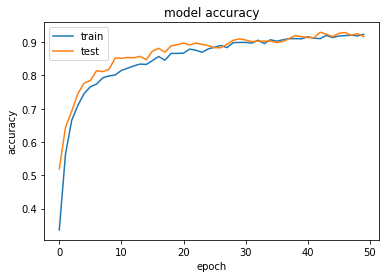

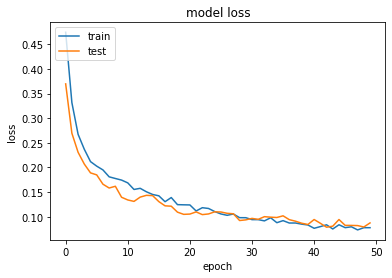

In [24]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

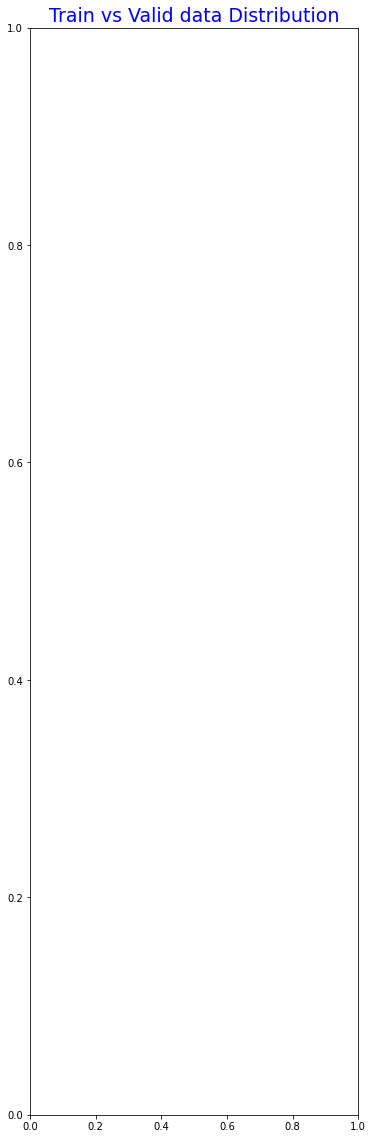

In [25]:
def image_information(data_set_info):
    plt.rcParams["font.size"]=14
    plt.pie([data_set_info.nb[data_set_info.Category=="healthy"].sum(),data_set_info.nb[data_set_info.Category!="health"].sum()],labels=["Healthy","Disease"],autopct=lambda x:str(round(x,1))+"%",colors=["#007CC3","#47B39C"],shadow=False,explode=(0.20,0))

    
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Train vs Valid data Distribution",fontsize=19,color="Blue")
plt.rcParams["font.size"]=14

total_data = 15350
train_ratio = 0.8

train_data_count = int(total_data * train_ratio)
valid_data_count = total_data - train_data_count


In [23]:

# image_information(valid_data_count)
plt.pie([valid_data_count.nb.sum(), train_data_count.nb.sum()], labels=["Valid Data", "Train Data"], autopct=lambda x: str(round(x,2)) + "%" , colors=["#FFA600", "#47B39C"], shadow=False, explode=(0.20,0))
plt.subplot(1,3,2)
plt.title("Train Data Set Healthy Vs Disease Plant "        "          "  ,fontsize=19,color="aqua")
image_information(train_data_count)
plt.subplot(1,3,3)
plt.title('Valid Data Set - Healthy VS Disease plant', fontsize=19,color="springgreen")
image_information(valid_data_count)
         

NameError: name 'valid_data_count' is not defined

In [21]:
model.save(f'./model/mobilenet_combined.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import os
[  os.listdir("./model")]

[['.DS_Store',
  '9',
  '7',
  '111',
  '6',
  '1',
  'AlexNet_nb.h5',
  'resnet50_combined.h5',
  'resnet50.h5',
  'vgg16_nb.h5',
  'mobilenet_combined.h5',
  'customcnn_nb.h5',
  '112',
  'MobieNet_nb.h5',
  '4',
  '3',
  '12',
  '2',
  '5']]

38/38 [==============================] - 7s 123ms/step


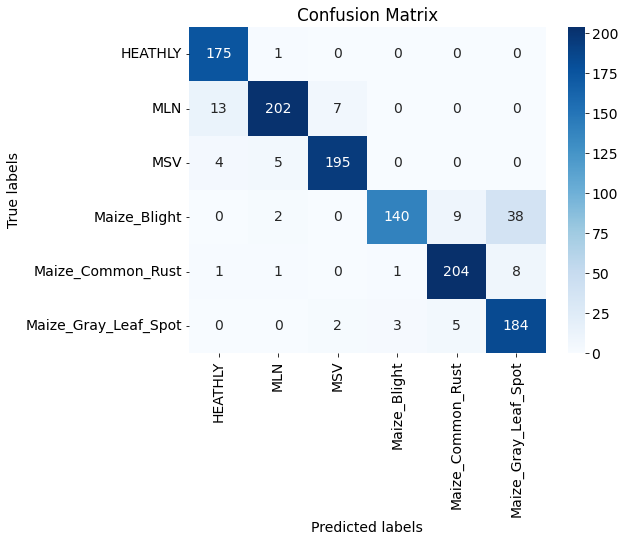

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicting the classes for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_alexnet=load_model(f'./model/mobilenet3d.h5')

In [26]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label_index = np.argmax(labels_batch[0].numpy())
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label_index])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


NameError: name 'test_ds' is not defined